In [1]:
# Importing standard Qiskit libraries
from qiskit import  QuantumCircuit, transpile
#from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
#service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [2]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import pylab

import networkx as nx

#from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit_optimization.converters import QuadraticProgramToQubo

from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

from itertools import permutations #per brutal approches TSP

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
#draw a graph coloring the nodes

#funzione per disegnare un grafo con nodi colorati
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

#funzione per disegnare un cammino su un grafo
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

### TSP

distance
 [[ 0. 74. 42. 76.]
 [74.  0. 67. 59.]
 [42. 67.  0. 39.]
 [76. 59. 39.  0.]]


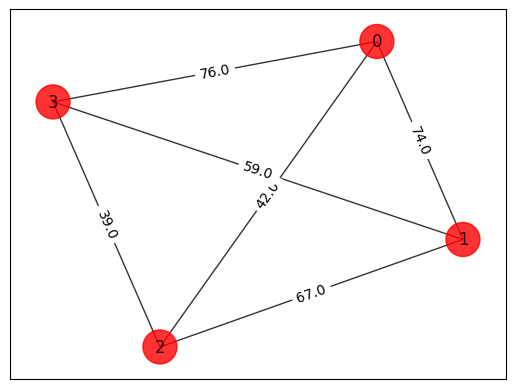

In [4]:
# Generating a random graph
n =4  # num
num_qubits = n**2
tsp = Tsp.create_random_instance(n)
G=tsp.graph


# Creating a specific graph

#n=3 #numero di nodi
#G= nx.Graph() # definizione del grafo
#G.add_nodes_from(np.arange(0, n, 1)) # aggiungo i vertici
#elist = [(0, 1, 1), (0, 2, 1), (1, 2, 3)] # definisco la lista degli archi [(i,j,peso)]
### tuple is (i,j,weight) where (i,j) is the edge
#G.add_weighted_edges_from(elist)# aggiungo gli archi al grafo

#tsp=Tsp(G)

# grafico
adj_matrix = nx.to_numpy_array(G)
print("distance\n", adj_matrix)
colors = ["r" for node in G.nodes]
pos = nx.spring_layout(G)
draw_graph(tsp.graph, colors, pos)


In [5]:
## define the ising model

qp = tsp.to_quadratic_program()
qp2qubo= QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()

In [6]:
###EXACT SOLUTION
###Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z= tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))

energy: -46212.0
tsp objective: 214.0
feasible: True
solution: [3, 1, 0, 2]
solution objective: 214.0


In [7]:
# create the ANSATZ

###standard ansatz
#ansatz= TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=2, entanglement="linear")

###specific ansatz no constrain Proposed 1
#theta = ParameterVector('theta', qubitOp.num_qubits)
#ansatz = QuantumCircuit(qubitOp.num_qubits)
#for i in range (0,qubitOp.num_qubits, tsp.graph.number_of_nodes()):
#    ansatz.x(i)
#    for j in range(i+1,i+tsp.graph.number_of_nodes(),1):
#        ansatz.ry(theta[j-1], j)
#        ansatz.cz(j-1,j)
#        ansatz.ry(-theta[j-1], j)
#    for j in range(i+1,i+tsp.graph.number_of_nodes(),1):
#        ansatz.cx(j,j-1)

In [8]:
# create the Ansatz Proposed 2
def W_circuit(QC, n, q1n, theta):
    QC.x(q1n)
    #QC.barrier(range(q1n,q1n+n))
    for j in range(q1n+1,q1n+n,1):
        QC.ry(theta[j-1], j)
        QC.cz(j-1,j)
        QC.ry(-theta[j-1], j)
        #QC.barrier(range(q1n,q1n+n))
    for j in range(q1n+1,q1n+n,1):
        QC.cx(j,j-1)

def base_circuit(QC, n, theta):
    theta1 = ParameterVector('theta2', 1)
    QC.x(0)
    #QC.barrier(range(0,n-1))
    QC.ry(theta[1], 1)
    QC.cz(0,1)
    QC.ry(-theta[1], 1)
    QC.cx(1,0)
    QC.cx(1,n)
    QC.cx(0,n+1)


In [9]:
qc = QuantumCircuit(n**2)
phi=ParameterVector('phi', n**2)
base_circuit(qc,n, phi)
for i in range(3,n+1,1):
    W_circuit(qc, i, n*(i-1), phi)
    #qc.barrier()
for k in range (3,n+1,1):
    for v in range(1,k,1):
        for p in range(1,k,1):
            qc.cswap(n*(k-1)+v-1,n*(p-1)+n-(n-k)-1,n*(p-1)+v-1)
ansatz=qc
#qc.draw('mpl',plot_barriers=False)

In [10]:
from qiskit.primitives import Sampler # per esecuzione in locale

In [11]:
# in locale
optimizer = COBYLA(maxiter=20) #define the optimizer
vqe= SamplingVQE(sampler=Sampler(), ansatz=ansatz, optimizer=optimizer) #define the SamplingVqe
# run SamplingVQE
result=vqe.compute_minimum_eigenvalue(qubitOp)



energy: -46192.894465798294
time: 1.6146669387817383
feasible: True
solution: [0, 1, 3, 2]
solution objective: 214.0


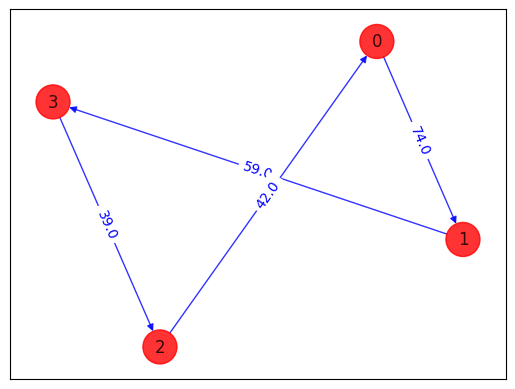

In [12]:
#result

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp.sample_most_likely(result.eigenstate)
print("feasible:", qp.is_feasible(x))
z = tsp.interpret(x) #cammino
print("solution:", z)
p=tsp.tsp_value(z, adj_matrix) # peso totale del cammino
print("solution objective:", p)
draw_tsp_solution(tsp.graph, z, colors, pos) #plot della soluzione

In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler #solo per eseguire il cicuito in runtime

In [14]:
my_api_token = '' #inserire Api token

In [15]:
service = QiskitRuntimeService(channel="ibm_quantum", token= my_api_token)

qiskit_runtime_service.__init__:INFO:2024-03-08 12:27:21,536: Default instance: ibm-q/open/main


In [16]:
optimizer = COBYLA(maxiter=20) #define the optimizer
backend=service.backend("ibmq_qasm_simulator") #scegli backend
with Session (backend=backend) as s:
    vqe_mes= SamplingVQE(sampler=Sampler(backend=backend, session=s), ansatz=ansatz, optimizer=optimizer) #define the SamplingVqe
    # run SamplingVQE
    vqe = MinimumEigenOptimizer ( vqe_mes )
    result = vqe . solve (qp)
    print(s.session_id)
s.close()

base_primitive._run_primitive:INFO:2024-03-08 12:27:22,586: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
base_primitive._run_primitive:INFO:2024-03-08 12:27:25,143: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
base_primitive._run_primitive:INFO:2024-03-08 12:27:27,709: Submitting job using options {'optim

None


fval=214.0, x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_0_3=0.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_1_3=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=1.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0, status=SUCCESS
objective function value: 214.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_0_3=0.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_1_3=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=1.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0
status: SUCCESS
solution: [3, 1, 0, 2]
solution objective: 214.0


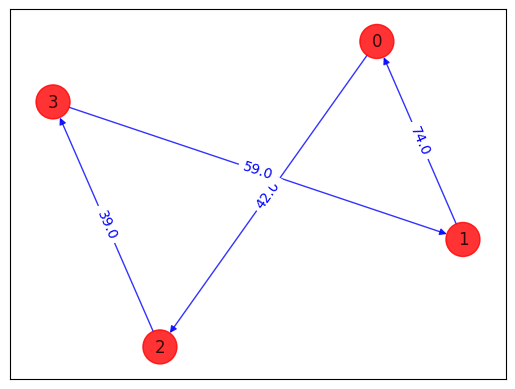

In [17]:
print(result)
print(result.prettyprint())
z=tsp.interpret(result)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [23]:
optimizer = COBYLA(maxiter=20) #define the optimizer
backend=service.backend("ibmq_qasm_simulator") #scegli backend
with Session (backend=backend) as s:
    vqe= SamplingVQE(sampler=Sampler(backend=backend, session=s), ansatz=ansatz, optimizer=optimizer) #define the SamplingVqe
    # run SamplingVQE
    result = vqe.compute_minimum_eigenvalue(qubitOp)
s.close()

base_primitive._run_primitive:INFO:2024-03-08 13:17:24,300: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
base_primitive._run_primitive:INFO:2024-03-08 13:17:29,377: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
base_primitive._run_primitive:INFO:2024-03-08 13:17:32,080: Submitting job using options {'optim

energy: -46211.08500000001
time: 204.6463484764099
feasible: True
solution: [3, 1, 0, 2]
solution objective: 214.0


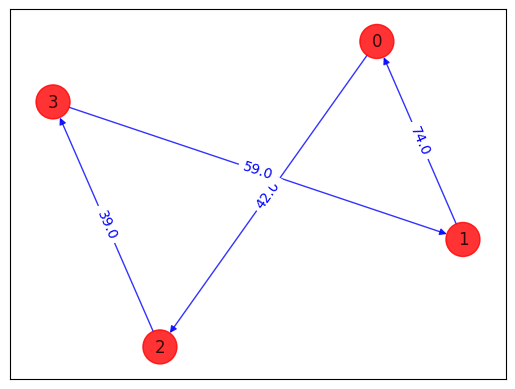

In [24]:
#result

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp.sample_most_likely(result.eigenstate)
print("feasible:", qp.is_feasible(x))
z = tsp.interpret(x) #cammino
print("solution:", z)
p=tsp.tsp_value(z, adj_matrix) # peso totale del cammino
print("solution objective:", p)
draw_tsp_solution(tsp.graph, z, colors, pos) #plot della soluzione